### Plan
1. Implement "volume knob" -> adjust amplitude for all ranges
2. Implement for 2 frequency ranges

### References
1. https://stackoverflow.com/questions/24920346/filtering-a-wav-file-using-python
2. https://octovoid.com/2017/11/04/coding-a-parametric-equalizer-for-audio-applications/
3. https://stackoverflow.com/questions/54932976/audio-equalizer

In [22]:
# This code just opens a wave file, reads the contents, and writes it to a new wave file

import wave
import numpy as np

input_file_path = './electric_guitar_sample.wav'
output_file_path = './outputs/test.wav'

def load_audio(file_path):
    audio_data = wave.open(file_path, 'r')
    return audio_data

def convert_to_numpy_array(data):
    audio_array = data.readframes(-1)
    audio_array = np.frombuffer(audio_array, dtype='int16')
    return audio_array

def write_to_wav_file(file_path, audio_array, channel_count, sample_width, samplerate):
    with wave.open(file_path, 'w') as f:
        f.setnchannels(channel_count)
        f.setsampwidth(sample_width)
        f.setframerate(samplerate)
        f.writeframes(audio_array.tobytes())

audio_data = load_audio(input_file_path)
audio_array = convert_to_numpy_array(audio_data)

channel_count = audio_data.getnchannels()
sample_width = audio_data.getsampwidth()
samplerate = 44100

write_to_wav_file(output_file_path, audio_array, channel_count, sample_width, samplerate)

TypeError: convert_to_numpy_array() missing 1 required positional argument: 'data'

[ 0  0 42 ...  4  4  2]
[-284031.          +0.j           82073.2904344 +387.56655809j
   82666.12022477-366.51989526j ...   84409.94003357-499.18620429j
   82666.12022477+366.51989526j   82073.2904344 -387.56655809j]


C:\Users\a01me\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\a01me\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


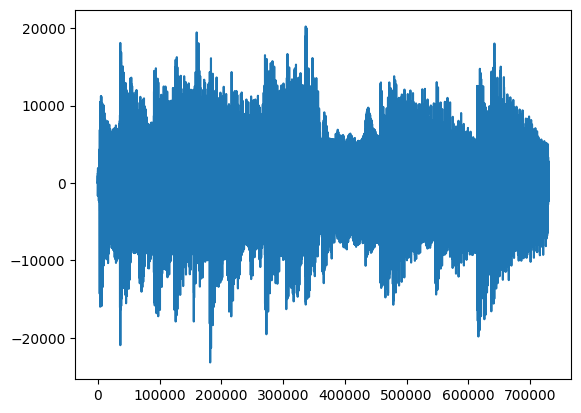

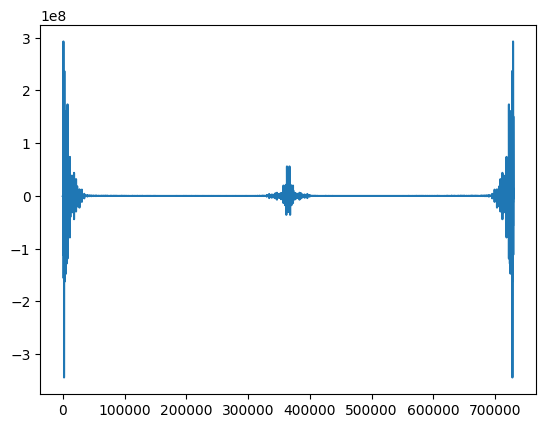

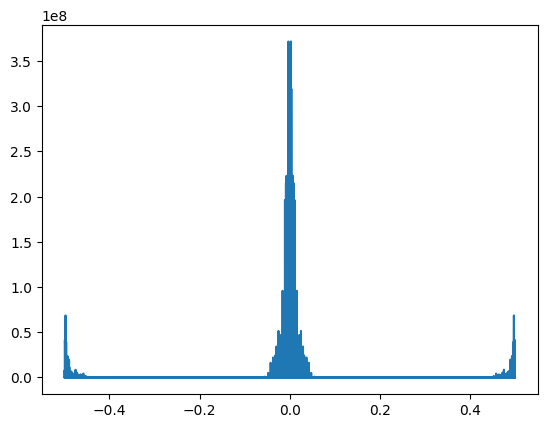

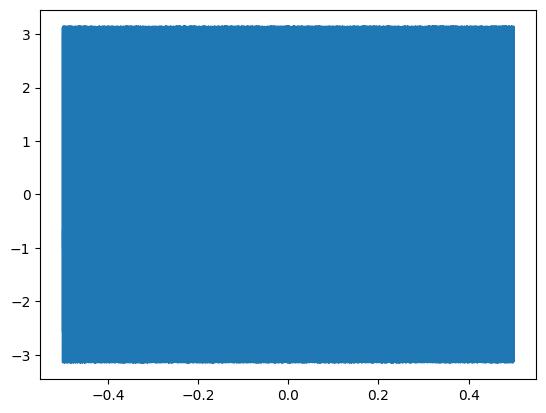

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import wave

def open_plot_file():

    file_path = './electric_guitar_sample.wav'

    audio_data = wave.open(file_path, 'r')

    audio_signal = audio_data.readframes(-1)
    audio_signal = np.frombuffer(audio_signal, dtype='int16')
    
    print(audio_signal)

    plt.figure(1)
    plt.plot(audio_signal)

    audio_fft = np.fft.fft(audio_signal)
    audio_freq = np.fft.fftfreq(len(audio_signal))
    
    print(audio_fft)
    
    plt.figure(2)
    plt.plot(audio_fft)
    
    Y    = np.fft.fft(audio_signal)
    freq = np.fft.fftfreq(len(audio_signal))

    plt.figure()
    plt.plot( freq, np.abs(Y) )
    plt.figure()
    plt.plot(freq, np.angle(Y) )
    plt.show()

def bandpass_filter(low_frequency, high_frequency, fs, num_taps = 101):
    pass

open_plot_file()

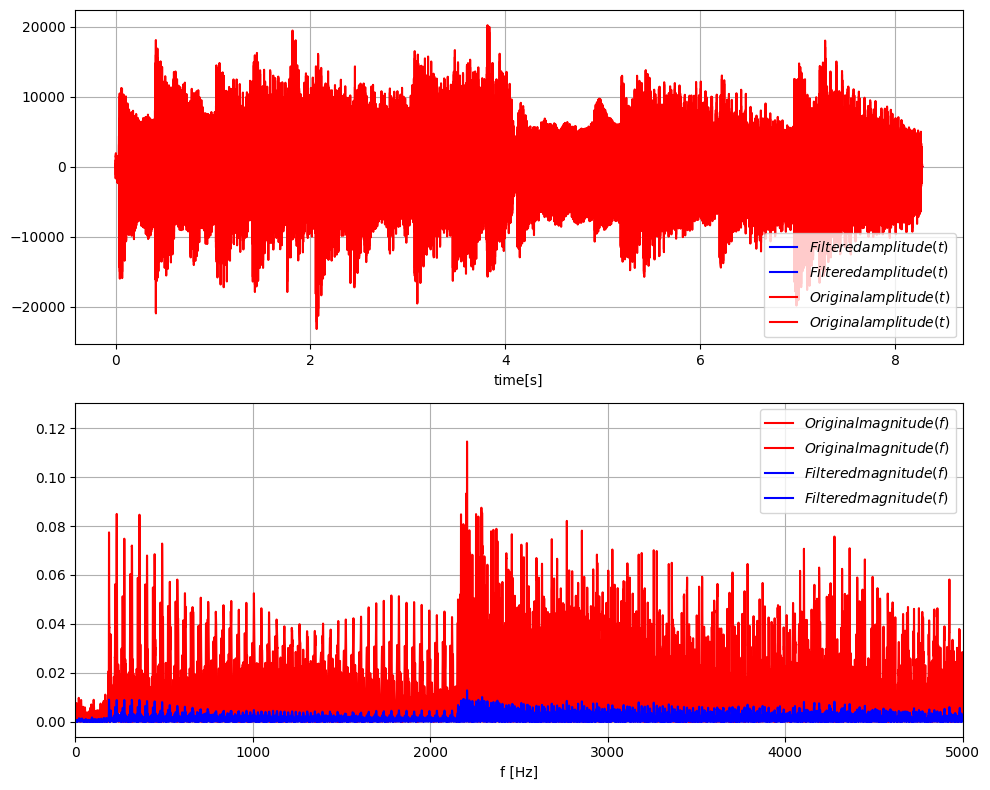

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from scipy import signal
from scipy.signal import butter, lfilter

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    filtered = lfilter(b, a, data)
    return filtered

def equalizer_10band (data, fs, gain1=0, gain2=0, gain3=0, gain4=0, gain5=0, gain6=0, gain7=0, gain8=0, gain9=0, gain10=0):
    band1 = bandpass_filter(data, 20, 39, fs, order=2)* 10**(gain1/20)
    band2 = bandpass_filter(data, 40, 79, fs, order=3)*10**(gain2/20)
    band3 = bandpass_filter(data, 80, 159, fs, order=3)*10**(gain3/20)
    band4 = bandpass_filter(data, 160, 299, fs, order=3)* 10**(gain4/20)
    band5 = bandpass_filter(data, 300, 599, fs, order=3)* 10**(gain5/20)
    band6 = bandpass_filter(data, 600, 1199, fs, order=3)* 10**(gain6/20)
    band7 = bandpass_filter(data, 1200, 2399, fs, order=3)* 10**(gain7/20)
    band8 = bandpass_filter(data, 2400, 4999, fs, order=3)* 10**(gain8/20)
    band9 = bandpass_filter(data, 5000, 9999, fs, order=3)* 10**(gain9/20)
    band10 = bandpass_filter(data, 10000, 20000, fs, order=3)* 10**(gain10/20)
    signal = band1 + band2 + band3 + band4 + band5 + band6 + band7 + band8 + band9 + band10
    return signal

freq_s, data = wav.read("electric_guitar_sample.wav")

N = len(data)
t  = 1/freq_s * np.arange(N) 
f  = freq_s/N * np.arange(N)

#computing fft of original signal
F_data = np.fft.fft(data)/N

#appying equalizer
equalized = equalizer_10band(data, freq_s, 0,0,0,0,0,0,0,0,0,0)

#computing fft of filtered signal
Y = np.fft.fft(equalized)/N

plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.plot(t, equalized,'-b',label=r"$Filtered amplitude(t)$")
plt.xlabel('time[s]')
plt.subplot(2,1,1)
plt.plot(t, data,'-r',label=r"$Original amplitude(t)$")
plt.xlabel('time[s]')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(f[:N//2],np.abs(F_data[:N//2]),'-r',label=r"$Original magnitude(f)$")
plt.xlabel('f [Hz]')
plt.xlim([0,5e3])
plt.plot(f[:N//2],np.abs(Y[:N//2]),'-b',label=r"$Filtered magnitude(f)$")
plt.xlabel('f [Hz]')
plt.xlim([0,5e3])
plt.legend()
plt.tight_layout()
plt.grid()

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlim'

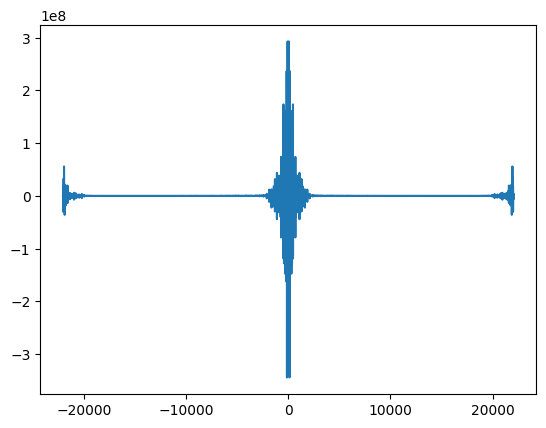

In [15]:
# generate a fft using numpy on a wav file and plot the result
import numpy as np
import wave
import matplotlib.pyplot as plt
import os

def perform_fft(signal, sample_rate):
    # perform the FFT
    fft = np.fft.fft(signal)
    # calculate the frequency bins
    frequency_bins = np.fft.fftfreq(len(signal), 1 / sample_rate)
    return fft, frequency_bins

files = ['electric_guitar_sample.wav']
files_set = set(files)
#create subplots
fig, files_set = plt.subplots(len(files))

# Open wave file
# iterate through files in audio_samples
for i, file  in enumerate(files):
    wav_file = wave.open('./' + file, 'r')

    # Extract Raw Audio from Wav File
    signal = wav_file.readframes(-1)
    frame_rate = wav_file.getframerate()
    signal = np.frombuffer(signal, dtype='int16')

    fft_out, frequency_bins = perform_fft(signal, frame_rate)

    # pane = files_set[i]
    #plot the fft
    plt.plot(frequency_bins, fft_out)

    #only show up to 20000Hz
    plt.set_xlim(100, 700)
    plt.set_ylim(0, 30)
    plt.set_title(file)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.5, wspace=0.5)
#show all the plots
plt.show()